# Monkey Classification: End-to-end Pipeline
In this notebook we're going to show how you can train and serve a simple model using Kubeflow pipelines!<br>

The dataset we're using consists of two folders; training and validation. Each folder contains 10 subforders labeled as n0~n9, each corresponding a species from Wikipedia's monkey cladogram. Images are 400x300 px or larger and JPEG format.

You'll need:
- Just this notebook
- Kubeflow deployed on either OpenShift or Kubernetes (make sure it is on IBM Power, we don't support x86!)
- Internet connection to download the sample images (you can also manually upload them to your preferred S3 bucket - e.g. minio)

Datasource: https://www.kaggle.com/slothkong/10-monkey-species

## Authors
- Marvin Giessing <MARVING@de.ibm.com>
- Sebastian Lehrig <sebastian.lehrig1@ibm.com>

## License
Apache-2.0 License

## 0.) Imports & Constants

In [297]:
#conda install -y opencv

In [295]:
import cv2
import json
import kfp
import kfp.components as comp
from typing import NamedTuple
import kfp.dsl as dsl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import requests

In [71]:
DOWNLOAD_AND_EXTRACT_COMPONENT_URL = "https://raw.githubusercontent.com/lehrig/kubeflow-ppc64le-components/main/data-extraction/download-and-extract-from-url/component.yaml"
CONVERT_MODEL_TO_ONNX_COMPONENT_URL = "https://raw.githubusercontent.com/lehrig/kubeflow-ppc64le-components/main/model-building/convert-to-onnx/component.yaml"
UPLOAD_MODEL_COMPONENT_URL = "https://raw.githubusercontent.com/lehrig/kubeflow-ppc64le-components/main/model-building/upload-model/component.yaml"
DEPLOY_MODEL_WITH_KSERVE_COMPONENT_URL = "https://raw.githubusercontent.com/lehrig/kubeflow-ppc64le-components/main/model-deployment/deploy-model-with-kserve/component.yaml"

DATASET_URL = "https://ibm.box.com/shared/static/cun7p8yo1haaxxwaag5l8czpjus15je8.zip"
DATASET_FILE_NAME = "data.zip"
MODEL_NAME = "monkey-classification"

MINIO_URL = "minio-service.kubeflow:9000"
MINIO_USER = "minio"
MINIO_PASS = "minio123"

with open("/var/run/secrets/kubernetes.io/serviceaccount/namespace") as f:
    NAMESPACE = f.read()
NAMESPACE

'kubeflow-user-example-com'

## 1.) Let's start with creating a client object for interaction

In [54]:
client = kfp.Client()

## 2.) The main part consists of defining the end-to-end workflow functions and create components from them
### 2.1) Download & extract data (by reusing a Kubeflow component)

In [55]:
download_and_extract_comp = comp.load_component_from_url(
    DOWNLOAD_AND_EXTRACT_COMPONENT_URL
)

### 2.2) Preprocess data (normalizing, one hot encoding etc)

In [56]:
def preprocess_data(
    data_dir: comp.InputPath(str),
    prep_data_dir: comp.OutputPath(str)
):
    """Open & resize data using cv2. Saves the .npz into `prep_data_dir`."""

    import os
    import cv2
    import glob
    import numpy as np

    TRAIN_FOLDER = f'{data_dir}/training/training'
    VAL_FOLDER = f'{data_dir}/validation/validation'

    def prepare(PATH, dset):
        fnames = sorted(glob.glob(PATH+'/*/*', recursive=True))
        print("Found {} files".format(len(fnames)))

        X = []
        y = []
        # For debugging: for f in fnames[int(len(fnames)*0.1)]:
        for f in fnames:
            X.append(cv2.resize(cv2.imread(f), dsize=(224, 224)))
            y.append(int(f.split('/')[-2][1]))

        X = np.array(X)
        y = np.array(y)

        X = X / 255.0
        y = np.eye(len(np.unique(y)))[y]

        print(f'The X-values shape: {X.shape} | y-values shape: {y.shape}')

        if not os.path.exists(prep_data_dir):
            os.makedirs(prep_data_dir)

        np.savez(f'/{prep_data_dir}/prepared_{dset}_data.npz', X, y)
        print(f'Data saved {prep_data_dir}')
        print(os.listdir(prep_data_dir))

    prepare(TRAIN_FOLDER, 'train')
    prepare(VAL_FOLDER, 'val')


preprocess_data_comp = kfp.components.create_component_from_func(
    func=preprocess_data,
    output_component_file='prep_data_component.yaml',
    base_image='quay.io/ibm/kubeflow-component-numpy-cv2:latest'
)

### 2.3) Train the model

In [57]:
def train_model(
    prep_data_dir: comp.InputPath(str),
    model_dir: comp.OutputPath(str)
):
    """Uses transfer learning for 5 epochs on a prepared dataset. Once trained, the model is persisted to `model_dir`."""

    import os
    import numpy as np
    from sklearn.model_selection import train_test_split
    from tensorflow.keras import Sequential
    from tensorflow.keras.applications import InceptionV3
    from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
    from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

    np_data = np.load(f'{prep_data_dir}/prepared_train_data.npz')
    X = np_data[np_data.files[0]]
    y = np_data[np_data.files[1]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    backbone = InceptionV3(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

    for layer in backbone.layers:
        layer.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(model.summary())

    earlyStopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=0,
        mode='min'
    )

    mcp_save = ModelCheckpoint(
        f'{model_dir}/best_model.hdf5',
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )

    reduce_lr_loss = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=7,
        verbose=1,
        epsilon=1e-4,
        mode='min'
    )

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    hist = model.fit(
        X_train,
        y_train,
        batch_size=4,
        epochs=10,
        validation_data=(X_test, y_test),
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
    )

    print("Model train history:")
    print(hist.history)

    model.save(model_dir)
    print(f"Model saved to: {model_dir}")


train_model_comp = kfp.components.create_component_from_func(
    func=train_model,
    output_component_file='train_model_component.yaml',
    base_image='quay.io/ibm/kubeflow-component-tensorflow-gpu:2.7.0-dev'
)

### 2.4) Evaluate model with validation data

In [58]:
def evaluate_model(
    prep_data_dir: comp.InputPath(str),
    model_dir: comp.InputPath(str),
    metrics_path: comp.OutputPath(str)
) -> NamedTuple("EvaluationOutput", [("mlpipeline_metrics", "Metrics")]):
    """Loads a saved model from file and uses a pre-downloaded dataset for evaluation.
    Model metrics are persisted to `/mlpipeline-metrics.json` for Kubeflow Pipelines
    metadata."""

    import json
    import numpy as np
    import tensorflow as tf
    from collections import namedtuple

    np_data = np.load(f'{prep_data_dir}/prepared_val_data.npz')
    X = np_data[np_data.files[0]]
    y = np_data[np_data.files[1]]

    model = tf.keras.models.load_model(model_dir)
    (loss, accuracy) = model.evaluate(X, y)

    print((loss, accuracy))

    metrics = {
        "metrics": [
            {
                "name": "loss",
                "numberValue": str(loss),
                "format": "PERCENTAGE"
            },
            {
                "name": "accuracy",
                "numberValue": str(accuracy),
                "format": "PERCENTAGE"},
        ]
    }

    with open(metrics_path, "w") as f:
        json.dump(metrics, f)

    out_tuple = namedtuple("EvaluationOutput", ["mlpipeline_metrics"])

    return out_tuple(json.dumps(metrics))


evaluate_model_comp = kfp.components.create_component_from_func(
    func=evaluate_model,
    output_component_file='eval_model_component.yaml',
    base_image='quay.io/ibm/kubeflow-component-tensorflow-cpu:latest'
)

### 2.5) Convert model to ONNX (by reusing a Kubeflow component)

In [59]:
convert_model_to_onnx_comp = comp.load_component_from_url(
    CONVERT_MODEL_TO_ONNX_COMPONENT_URL
)

### 2.6) Upload model to MinIO artifact store (by reusing a Kubeflow component)

In [60]:
upload_model_comp = comp.load_component_from_url(
    UPLOAD_MODEL_COMPONENT_URL
)

### 2.7) Deploy the model using KServe (by reusing a Kubeflow component)

In [61]:
deploy_model_with_kserve_comp = comp.load_component_from_url(
    DEPLOY_MODEL_WITH_KSERVE_COMPONENT_URL
)

## 3.) Create the actual pipeline by combining the components

In [11]:
@dsl.pipeline(
  name='End-to-end monkey species classification pipeline',
  description='An example pipeline that performs an image classification and determines different monkey species'
)
def monkey_pipeline(dataset_url: str,
                    dataset_file_name: str = "data.zip",
                    data_dir: str = "/train/data",
                    prep_data_dir: str = "/train/prep_data",
                    model_dir: str = "/train/model",
                    model_name: str = "monkey-classification",
                    minio_url: str = MINIO_URL,
                    minio_user: str = MINIO_USER,
                    minio_pass: str = MINIO_PASS):
    download_and_extract_task = download_and_extract_comp(
        url=dataset_url,
        file_name=dataset_file_name
    )

    preprocess_data_task = preprocess_data_comp(
        download_and_extract_task.outputs['data_path']
    )

    train_model_task = train_model_comp(
        preprocess_data_task.output
    ).set_gpu_limit(1)

    evaluate_model_task = evaluate_model_comp(
        preprocess_data_task.output,
        train_model_task.output
    )

    convert_model_to_onnx_task = convert_model_to_onnx_comp(
        train_model_task.output
    )

    upload_model_task = upload_model_comp(
        convert_model_to_onnx_task.output,
        minio_url,
        minio_user,
        minio_pass,
        model_name=model_name
    )

    deploy_model_with_kserve_task = deploy_model_with_kserve_comp(
        model_name=model_name
    )

    deploy_model_with_kserve_task.after(upload_model_task)

## 4.) Run the pipline within an experiment
Create a pipeline run, using the client you initialized in a prior step.

In [12]:
# Specify argument values for your pipeline run.
arguments = {
    'dataset_url': DATASET_URL,
    'dataset_file_name': DATASET_FILE_NAME,
    'data_dir': '/train/data',
    'prep_data_dir': '/train/prep_data',
    'model_dir': '/train/model',
    'model_name': MODEL_NAME,
    'minio_url': MINIO_URL,
    'minio_user': MINIO_USER,
    'minio_pass': MINIO_PASS
}

client.create_run_from_pipeline_func(
    monkey_pipeline,
    arguments=arguments,
    namespace=NAMESPACE
)

RunPipelineResult(run_id=a45d0ac2-3907-490c-b02f-792218424ff1)

## 5.) Test model deployment
See API documentation: https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md

### 5.1) Check model endpoint availability

In [272]:
HOST = MODEL_NAME + "-predictor-default." + NAMESPACE
HEADERS = {'Host': HOST}
MODEL_ENDPOINT = "http://" + MODEL_NAME + "-predictor-default/v2/models/" + MODEL_NAME

res = requests.get(MODEL_ENDPOINT, headers=HEADERS)
response = json.loads(res.text)
response

{'name': 'monkey-classification',
 'versions': ['1'],
 'platform': 'onnxruntime_onnx',
 'inputs': [{'name': 'inception_v3_input',
   'datatype': 'FP32',
   'shape': [-1, 224, 224, 3]}],
 'outputs': [{'name': 'dense_2', 'datatype': 'FP32', 'shape': [-1, 10]}]}

Note you can also do this:
```curl -H "Host: $HOST" $MODEL_ENDPOINT```

### 5.2) Get test image

In [286]:
IMAGE = "Monkey.jpg"
IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/0/00/Uakari_male.jpg" #Uakari
IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/Panamanian_Male_Adult_Howler_Monkey.jpg/2560px-Panamanian_Male_Adult_Howler_Monkey.jpg" # Howler
IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/c/c6/Patas_Monkey.jpg" # Patas
MONKEYS = np.array(["Mantled howler (Alouatta palliata)",
                    "Patas monkey (Erythrocebus patas)",
                    "Bald uakari (Cacajao calvus)",
                    "Japanese macaque (Macaca fuscata)",
                    "Pygmy marmoset (Cebuella pygmaea)",
                    "Colombian white-faced capuchin (Cebus capucinus)",
                    "Silvery marmoset (Mico argentatus)",
                    "Common squirrel monkey (Saimiri sciureus)",
                    "Black headed night monkey (Aotus nigriceps)",
                    "Nilgiri langur (Trachypithecus johnii)"]) # Note: last monkey after sorting

In [287]:
!wget $IMAGE_URL -O $IMAGE

--2022-04-14 15:53:51--  https://upload.wikimedia.org/wikipedia/commons/0/00/Uakari_male.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164736 (161K) [image/jpeg]
Saving to: ‘Monkey.jpg’

Monkey.jpg          100%[===================>] 160.88K  --.-KB/s    in 0.1s    

2022-04-14 15:53:51 (1.53 MB/s) - ‘Monkey.jpg’ saved [164736/164736]



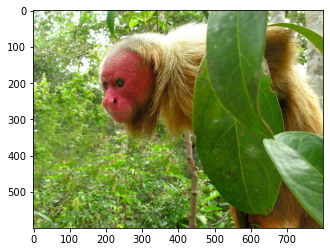

In [288]:
image = mpimg.imread(IMAGE)
image_plot = plt.imshow(image)

### 5.3) Predict monkey kind of test image

In [296]:
PREDICT_ENDPOINT = MODEL_ENDPOINT + "/infer"

test_image = cv2.resize(cv2.imread(IMAGE), dsize=(224, 224))
payload = {
  "inputs": [{
      "name": "inception_v3_input",
      "shape": [1, 224, 224, 3],
      "datatype": "FP32",
      "data": test_image.tolist()
    }
  ]
}

res = requests.post(PREDICT_ENDPOINT, headers=HEADERS, data=json.dumps(payload))
response = json.loads(res.text)
response

{'model_name': 'monkey-classification',
 'model_version': '1',
 'outputs': [{'name': 'dense_2',
   'datatype': 'FP32',
   'shape': [1, 10],
   'data': [4.191168523348665e-10,
    5.090545524512783e-31,
    0.0,
    4.0520981779799513e-25,
    0.0,
    0.0,
    0.0,
    1.2966930809964741e-36,
    0.03352715075016022,
    0.9664728045463562]}]}

Note you can also do this:
```curl -s -X POST -H "Host: $HOST" -d @$JSON_FILE $PREDICT_ENDPOINT```

In [291]:
print("Looks like a " + MONKEYS[np.argmax(response['outputs'][0]['data'])])

Looks like a Nilgiri langur (Trachypithecus johnii)
